In [217]:
import pandas as pd
import regex as re
from IPython.core.display_functions import display

In [218]:
data1 = pd.read_fwf('local-exp-gl2-data.txt', skiprows=[1], index_col=None)
data2 = pd.read_fwf('local-exp-gl6-data.txt', skiprows=[1], index_col=None)
data3 = pd.read_fwf('local-exp-gl5-data.txt', skiprows=[1], index_col=None)
data4 = pd.read_fwf('local-exp-gl2_2-data.txt', skiprows=[1], index_col=None)
data = pd.concat([data1, data2, data3, data4], axis=0, ignore_index=True)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,43453,daa-local-nc4_gl2-12.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4,NaN
325,43456,dpp-local-nc2_gl2-11.cfg,gl2_gl4,None assigned,CANCELLED+,None,2023-12-14T06:23:51,0,NaN,NaN,NaN,NaN,00:00:00,2,NaN
326,43459,daa-local-nc4_gl2-14.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4,NaN
327,43462,daa-local-nc2_gl2-17.cfg,gl2_gl4,None assigned,CANCELLED+,None,2023-12-14T06:23:50,0,NaN,NaN,NaN,NaN,00:00:00,2,NaN


In [219]:
def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [220]:
def filter_out_completed_jobs(dat):
    dat = dat[dat.State == 'COMPLETED']
    dat.JobName = dat.JobName.replace('batch', method='ffill')
    return dat.dropna(subset=['ConsumedEnergy'])


def extract_params_from_local_file_name(dat):
    dat[['Workflow', 'mode', 'ncores', 'node', 'trial']] = dat.JobName.str.extract(
        r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
    dat.ncores = dat.ncores.astype(int)
    dat.trial = dat.trial.astype(int)
    return dat


def append_job_data_columns(dat):
    for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
        dat[column] = dat[column].apply(convert_to_numeric)
        dat[f"{column}K"] = dat[column] / 1000
        dat[f"{column}M"] = dat[column] / 1_000_000
        dat[f"{column}G"] = dat[column] / 1_000_000_000
    dat['ElapsedSeconds'] = dat.Elapsed.apply(convert_elapsed_time)
    dat['ElapsedMinutes'] = dat.ElapsedSeconds / 60
    dat['ElapsedHours'] = dat.ElapsedMinutes / 60
    return dat


In [221]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

data_completed = filter_out_completed_jobs(data)
data_completed = data_completed[~data_completed.JobName.str.contains("nc2")].reset_index(drop=True)

data_pending = data[data.State == "PENDING"]
data_pending = data_pending[~data_pending.JobName.str.contains("nc2")].reset_index(drop=True)

data = pd.concat([data_completed, data_pending], axis=0, ignore_index=True)
data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)

# data = data[~data.JobName.str.contains("nc2")].reset_index(drop=True)
data = extract_params_from_local_file_name(data)
data_completed = extract_params_from_local_file_name(data_completed)
data_pending = extract_params_from_local_file_name(data_pending)

data_completed = append_job_data_columns(data_completed)
data_completed = data_completed.sort_values(by=['ncores', 'Workflow'])

display(data_completed, data_pending, data)

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_4984\3033834533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.JobName = dat.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskReadG,AveDiskWriteK,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours
8,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,88.38186,12728740.0,12728.74,12.72874,19389280.0,19389.280,19.389280,59539,992.316667,16.538611
9,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,88.38420,12731990.0,12731.99,12.73199,19387324.0,19387.324,19.387324,59646,994.100000,16.568333
13,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,88.38194,12728740.0,12728.74,12.72874,19389224.0,19389.224,19.389224,59279,987.983333,16.466389
16,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,88.38404,12731830.0,12731.83,12.73183,19388960.0,19388.960,19.388960,59157,985.950000,16.432500
17,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,88.38194,12728740.0,12728.74,12.72874,19388384.0,19388.384,19.388384,59174,986.233333,16.437222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,43147.batch,dpp-local-nc32_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:01:24,2023-12-09T07:22:39,197680.0,3.873032e+09,5.341920e+09,...,5.34192,804840.0,804.84,0.80484,193714440.0,193714.440,193.714440,1275,21.250000,0.354167
69,43150.batch,dpp-local-nc32_gl6-4.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:27:41,2023-12-09T07:48:33,195400.0,3.867044e+09,5.345240e+09,...,5.34524,804960.0,804.96,0.80496,193700144.0,193700.144,193.700144,1252,20.866667,0.347778
79,43183.batch,dpp-local-nc32_gl6-2.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T17:12:45,2023-12-11T17:33:47,196660.0,4.058076e+09,5.341920e+09,...,5.34192,804470.0,804.47,0.80447,193714776.0,193714.776,193.714776,1262,21.033333,0.350556
81,43189.batch,dpp-local-nc32_gl6-9.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T18:55:52,2023-12-11T19:16:50,196530.0,3.991680e+09,5.343420e+09,...,5.34342,804960.0,804.96,0.80496,193691408.0,193691.408,193.691408,1258,20.966667,0.349444


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
0,43234,daa-local-nc32_gl6-5.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,daa,local,32,gl6,5
1,43237,daa-local-nc16_gl6-2.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,daa,local,16,gl6,2
2,43243,dpp-local-nc16_gl6-4.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,dpp,local,16,gl6,4
3,43246,dpp-local-nc32_gl6-3.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,dpp,local,32,gl6,3
4,43249,dpp-local-nc32_gl6-10.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,dpp,local,32,gl6,10
5,43252,daa-local-nc16_gl6-9.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,daa,local,16,gl6,9
6,43261,dpp-local-nc4_gl6-8.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4,dpp,local,4,gl6,8
7,43288,dpp-local-nc32_gl5-12.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,dpp,local,32,gl5,12
8,43291,daa-local-nc16_gl5-11.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,daa,local,16,gl5,11
9,43294,dpp-local-nc8_gl5-11.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,8,dpp,local,8,gl5,11


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
0,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,dpp,local,4,gl2,9
1,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,dpp,local,4,gl2,3
2,42802.batch,dpp-local-nc4_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T13:24:15,2023-11-29T14:33:08,197.03K,629740K,5345.30M,802.60M,18558724K,01:08:53,4,dpp,local,4,gl2,2
3,42805.batch,dpp-local-nc8_gl2-4.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T14:38:13,2023-11-29T15:32:28,185.84K,1126708K,5345.41M,802.71M,36357232K,00:54:15,8,dpp,local,8,gl2,4
4,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4,dpp,local,4,gl2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,43429,daa-local-nc8_gl2-12.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,8,daa,local,8,gl2,12
125,43435,dpp-local-nc8_gl2-11.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,8,dpp,local,8,gl2,11
126,43441,dpp-local-nc8_gl2-14.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,8,dpp,local,8,gl2,14
127,43453,daa-local-nc4_gl2-12.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4,daa,local,4,gl2,12


In [222]:
jobs_to_eliminate = data[data.ncores == 2]
" ".join(map(str, list(jobs_to_eliminate.JobID.to_list())))

''

In [223]:
gl2_trials = data[data.node == "gl2"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    # trials_count=('trial', 'count'),
    # trials_list=('trial', lambda x: x.tolist()),
    # trials_left=('trial', lambda x: list(set(range(1, 11)) - set(x.tolist()))),
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
gl2_trials

,Workflow,mode,ncores,node,trials_left_count
0,daa,local,4,gl2,0
1,daa,local,8,gl2,1
2,dpp,local,4,gl2,0
3,dpp,local,8,gl2,0


In [224]:
gl2_trials_left = data_completed[data_completed.node == "gl2"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
gl2_trials_left.to_csv('gl2_trials_left.csv', index=False, header=True)
gl2_trials_left

,Workflow,mode,ncores,node,trials_left_count
0,daa,local,4,gl2,4
1,daa,local,8,gl2,2
2,dpp,local,4,gl2,0
3,dpp,local,8,gl2,3


In [225]:
gl6_trials_left = data_completed[data_completed.node == "gl6"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
gl6_trials_left.to_csv('gl6_trials_left.csv', index=False, header=True)
gl6_trials_left

,Workflow,mode,ncores,node,trials_left_count
0,daa,local,4,gl6,1
1,daa,local,8,gl6,4
2,daa,local,16,gl6,2
3,daa,local,32,gl6,1
4,dpp,local,4,gl6,3
5,dpp,local,8,gl6,2
6,dpp,local,16,gl6,2
7,dpp,local,32,gl6,3


In [226]:
gl6_trials_failed = data[data.node == "gl6"].sort_values(
    by=['Workflow', "node", "ncores", "trial"]).groupby(['Workflow', 'mode', 'ncores', 'node']).agg(
    trials_left_count=('trial', lambda x: 10 - len(x.tolist())),
).reset_index()
start_idx = 11
gl6_trials_failed['code'] = gl6_trials_failed.apply(lambda
                                                        x: f'[LocalConfig("{x.Workflow}", "{x.node}", trial, {x.ncores}) for trial in range({start_idx}, {start_idx} + {x.trials_left_count})]',
                                                    axis=1)
# LocalConfig("dpp", "gl5", trial, 32) for trial in range(11, 11 + 4)]
gl6_trials_failed.to_csv('gl6_trials_failed.csv', index=False, header=True)
display(gl6_trials_failed)
print(" + ".join(gl6_trials_failed.code.to_list()))

,Workflow,mode,ncores,node,trials_left_count,code
0,daa,local,4,gl6,1,"[LocalConfig(""daa"", ""gl6"", trial, 4) for trial..."
1,daa,local,8,gl6,4,"[LocalConfig(""daa"", ""gl6"", trial, 8) for trial..."
2,daa,local,16,gl6,0,"[LocalConfig(""daa"", ""gl6"", trial, 16) for tria..."
3,daa,local,32,gl6,0,"[LocalConfig(""daa"", ""gl6"", trial, 32) for tria..."
4,dpp,local,4,gl6,2,"[LocalConfig(""dpp"", ""gl6"", trial, 4) for trial..."
5,dpp,local,8,gl6,2,"[LocalConfig(""dpp"", ""gl6"", trial, 8) for trial..."
6,dpp,local,16,gl6,1,"[LocalConfig(""dpp"", ""gl6"", trial, 16) for tria..."
7,dpp,local,32,gl6,1,"[LocalConfig(""dpp"", ""gl6"", trial, 32) for tria..."


[LocalConfig("daa", "gl6", trial, 4) for trial in range(11, 11 + 1)] + [LocalConfig("daa", "gl6", trial, 8) for trial in range(11, 11 + 4)] + [LocalConfig("daa", "gl6", trial, 16) for trial in range(11, 11 + 0)] + [LocalConfig("daa", "gl6", trial, 32) for trial in range(11, 11 + 0)] + [LocalConfig("dpp", "gl6", trial, 4) for trial in range(11, 11 + 2)] + [LocalConfig("dpp", "gl6", trial, 8) for trial in range(11, 11 + 2)] + [LocalConfig("dpp", "gl6", trial, 16) for trial in range(11, 11 + 1)] + [LocalConfig("dpp", "gl6", trial, 32) for trial in range(11, 11 + 1)]


In [227]:
collected_data_stats = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).describe().reset_index()
collected_data_stats.to_csv(
    'local_exp_overview_stats.csv', header=True)
collected_data_stats

Workflow   mode ncores node ConsumedEnergy                              \
                                        count          mean           std   
0       daa  local      4  gl2            6.0  3.033333e+06   5163.977795   
1       daa  local      4  gl6            9.0  7.546667e+06  23979.157617   
2       daa  local      8  gl2            8.0  2.740000e+06   5345.224838   
3       daa  local      8  gl6            6.0  4.723333e+06  33862.466931   
4       daa  local     16  gl6            8.0  3.177500e+06  16690.459208   
5       daa  local     32  gl5            1.0  2.450000e+06           NaN   
6       daa  local     32  gl6            9.0  2.701111e+06  12692.955176   
7       dpp  local      4  gl2           10.0  1.965890e+05    586.296285   
8       dpp  local      4  gl6            7.0  5.118743e+05   1463.362078   
9       dpp  local      8  gl2            7.0  1.861029e+05    561.358895   
10      dpp  local      8  gl5            1.0  2.818900e+05           NaN   
11      dpp  local      8  gl6            8.0  3.226125e+05   3280.207964   
12      dpp  local     16  gl6            8.0  2.248675e+05   2220.255777   
13      dpp  local     32  gl6            7.0  1.970629e+05    917.273392   

                                     ... ElapsedMinutes               \
          min        25%        50%  ...            75%          max   
0   3030000.0  3030000.0  3030000.0  ...     991.233333   994.100000   
1   7510000.0  7530000.0  7550000.0  ...    1035.083333  1042.383333   
2   2730000.0  2740000.0  2740000.0  ...     783.179167   785.216667   
3   4700000.0  4702500.0  4715000.0  ...     589.154167   599.516667   
4   3150000.0  3167500.0  3180000.0  ...     353.375000   355.983333   
5   2450000.0  2450000.0  2450000.0  ...     287.766667   287.766667   
6   2690000.0  2690000.0  2700000.0  ...     279.000000   283.600000   
7    195420.0   196280.0   196835.0  ...      68.504167    68.883333   
8    509860.0   511145.0   511620.0  ...      72.583333    73.116667   
9    185290.0   185775.0   186130.0  ...      54.383333    54.866667   
10   281890.0   281890.0   281890.0  ...      43.250000    43.250000   
11   320560.0   321000.0   321375.0  ...      41.533333    43.183333   
12   222130.0   223675.0   224875.0  ...      26.591667    27.983333   
13   195400.0   196595.0   197470.0  ...      21.308333    21.800000   

   ElapsedHours                                                        \
          count       mean       std        min        25%        50%   
0           6.0  16.469676  0.071965  16.375000  16.433681  16.451806   
1           9.0  17.243580  0.065722  17.164722  17.212222  17.236111   
2           8.0  13.025694  0.041397  12.959444  13.000764  13.030694   
3           6.0   9.819537  0.090765   9.739167   9.764514   9.805833   
4           8.0   5.872187  0.033003   5.832778   5.845000   5.869722   
5           1.0   4.796111       NaN   4.796111   4.796111   4.796111   
6           9.0   4.631049  0.045546   4.579444   4.606111   4.622778   
7          10.0   1.132500  0.012449   1.111667   1.123472   1.133611   
8           7.0   1.207778  0.006132   1.199167   1.204861   1.207500   
9           7.0   0.901627  0.009430   0.888333   0.895833   0.904167   
10          1.0   0.720833       NaN   0.720833   0.720833   0.720833   
11          8.0   0.693229  0.010970   0.686111   0.687431   0.690417   
12          8.0   0.441493  0.012764   0.428889   0.433194   0.438056   
13          7.0   0.353135  0.005316   0.347778   0.350000   0.350556   

                          
          75%        max  
0   16.520556  16.568333  
1   17.251389  17.373056  
2   13.052986  13.086944  
3    9.819236   9.991944  
4    5.889583   5.933056  
5    4.796111   4.796111  
6    4.650000   4.726667  
7    1.141736   1.148056  
8    1.209722   1.218611  
9    0.906389   0.914444  
10   0.720833   0.720833  
11   0.692222   0.719722  
12   0.443194   0.466389  
13   0.355139   0.363333  

[14 rows x 204 

In [228]:
# All collected data
collected_data = data_completed.groupby(['Workflow', 'mode', 'ncores', 'node']).size().reset_index(
    name='count').sort_values(
    by=['Workflow', "node", "ncores"])
collected_data.to_csv('local_exp_overview.csv', index=False, header=True)
collected_data

,Workflow,mode,ncores,node,count
0,daa,local,4,gl2,6
2,daa,local,8,gl2,8
5,daa,local,32,gl5,1
1,daa,local,4,gl6,9
3,daa,local,8,gl6,6
4,daa,local,16,gl6,8
6,daa,local,32,gl6,9
7,dpp,local,4,gl2,10
9,dpp,local,8,gl2,7
10,dpp,local,8,gl5,1


In [229]:
data_completed['n_trials_completed'] = data_completed.sort_values(
    by=['Workflow', "node", "ncores"]).groupby(['Workflow', 'mode', 'ncores', 'node']).Workflow.transform('count')
data_completed['n_trials_threshold'] = data_completed['n_trials_completed'] >= 2
data_completed

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,...,AveDiskWriteM,AveDiskWriteG,AveVMSizeK,AveVMSizeM,AveVMSizeG,ElapsedSeconds,ElapsedMinutes,ElapsedHours,n_trials_completed,n_trials_threshold
8,42826.batch,daa-local-nc4_gl2-5.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-30T22:09:05,2023-12-01T14:41:24,3040000.0,1.296320e+09,8.838186e+10,...,12728.74,12.72874,19389280.0,19389.280,19.389280,59539,992.316667,16.538611,6,True
9,42832.batch,daa-local-nc4_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-01T14:46:26,2023-12-02T07:20:32,3040000.0,1.192524e+09,8.838420e+10,...,12731.99,12.73199,19387324.0,19387.324,19.387324,59646,994.100000,16.568333,6,True
13,42853.batch,daa-local-nc4_gl2-6.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-02T15:29:44,2023-12-03T07:57:43,3030000.0,1.181660e+09,8.838194e+10,...,12728.74,12.72874,19389224.0,19389.224,19.389224,59279,987.983333,16.466389,6,True
16,42871.batch,daa-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-03T10:13:21,2023-12-04T02:39:18,3030000.0,1.164340e+09,8.838404e+10,...,12731.83,12.73183,19388960.0,19388.960,19.388960,59157,985.950000,16.432500,6,True
17,42874.batch,daa-local-nc4_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-12-04T02:44:22,2023-12-04T19:10:36,3030000.0,1.185192e+09,8.838194e+10,...,12728.74,12.72874,19388384.0,19388.384,19.388384,59174,986.233333,16.437222,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,43147.batch,dpp-local-nc32_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:01:24,2023-12-09T07:22:39,197680.0,3.873032e+09,5.341920e+09,...,804.84,0.80484,193714440.0,193714.440,193.714440,1275,21.250000,0.354167,7,True
69,43150.batch,dpp-local-nc32_gl6-4.cfg,gl2_gl4,gl6,COMPLETED,2023-12-09T07:27:41,2023-12-09T07:48:33,195400.0,3.867044e+09,5.345240e+09,...,804.96,0.80496,193700144.0,193700.144,193.700144,1252,20.866667,0.347778,7,True
79,43183.batch,dpp-local-nc32_gl6-2.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T17:12:45,2023-12-11T17:33:47,196660.0,4.058076e+09,5.341920e+09,...,804.47,0.80447,193714776.0,193714.776,193.714776,1262,21.033333,0.350556,7,True
81,43189.batch,dpp-local-nc32_gl6-9.cfg,gl2_gl4,gl6,COMPLETED,2023-12-11T18:55:52,2023-12-11T19:16:50,196530.0,3.991680e+09,5.343420e+09,...,804.96,0.80496,193691408.0,193691.408,193.691408,1258,20.966667,0.349444,7,True


In [230]:
import matplotlib.pyplot as plt

In [231]:
data_for_analysis = data_completed[data_completed.n_trials_threshold].reset_index(drop=True)

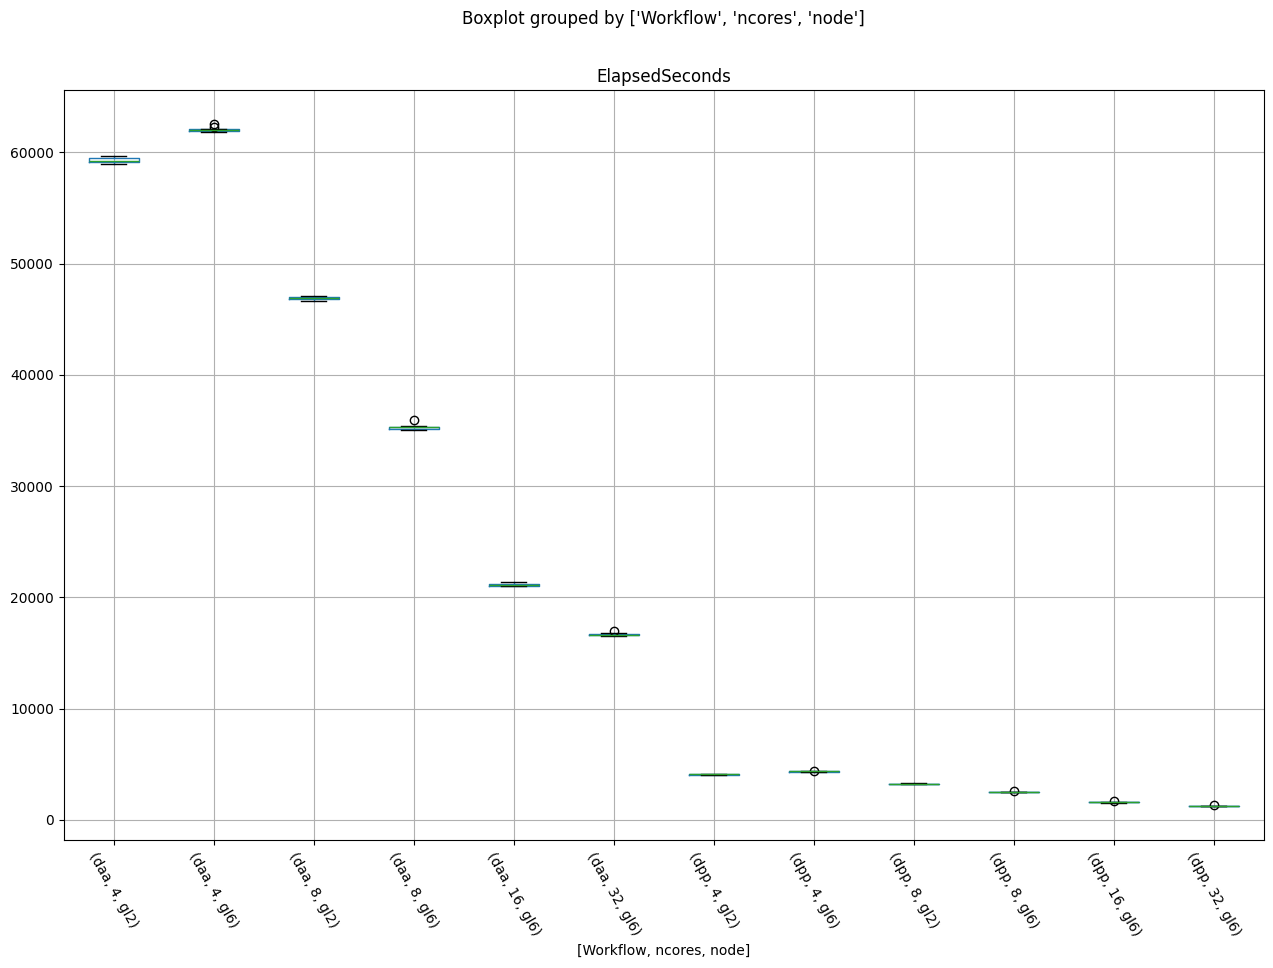

In [232]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data_for_analysis.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-60)
# save
fig.savefig('boxplot.png')


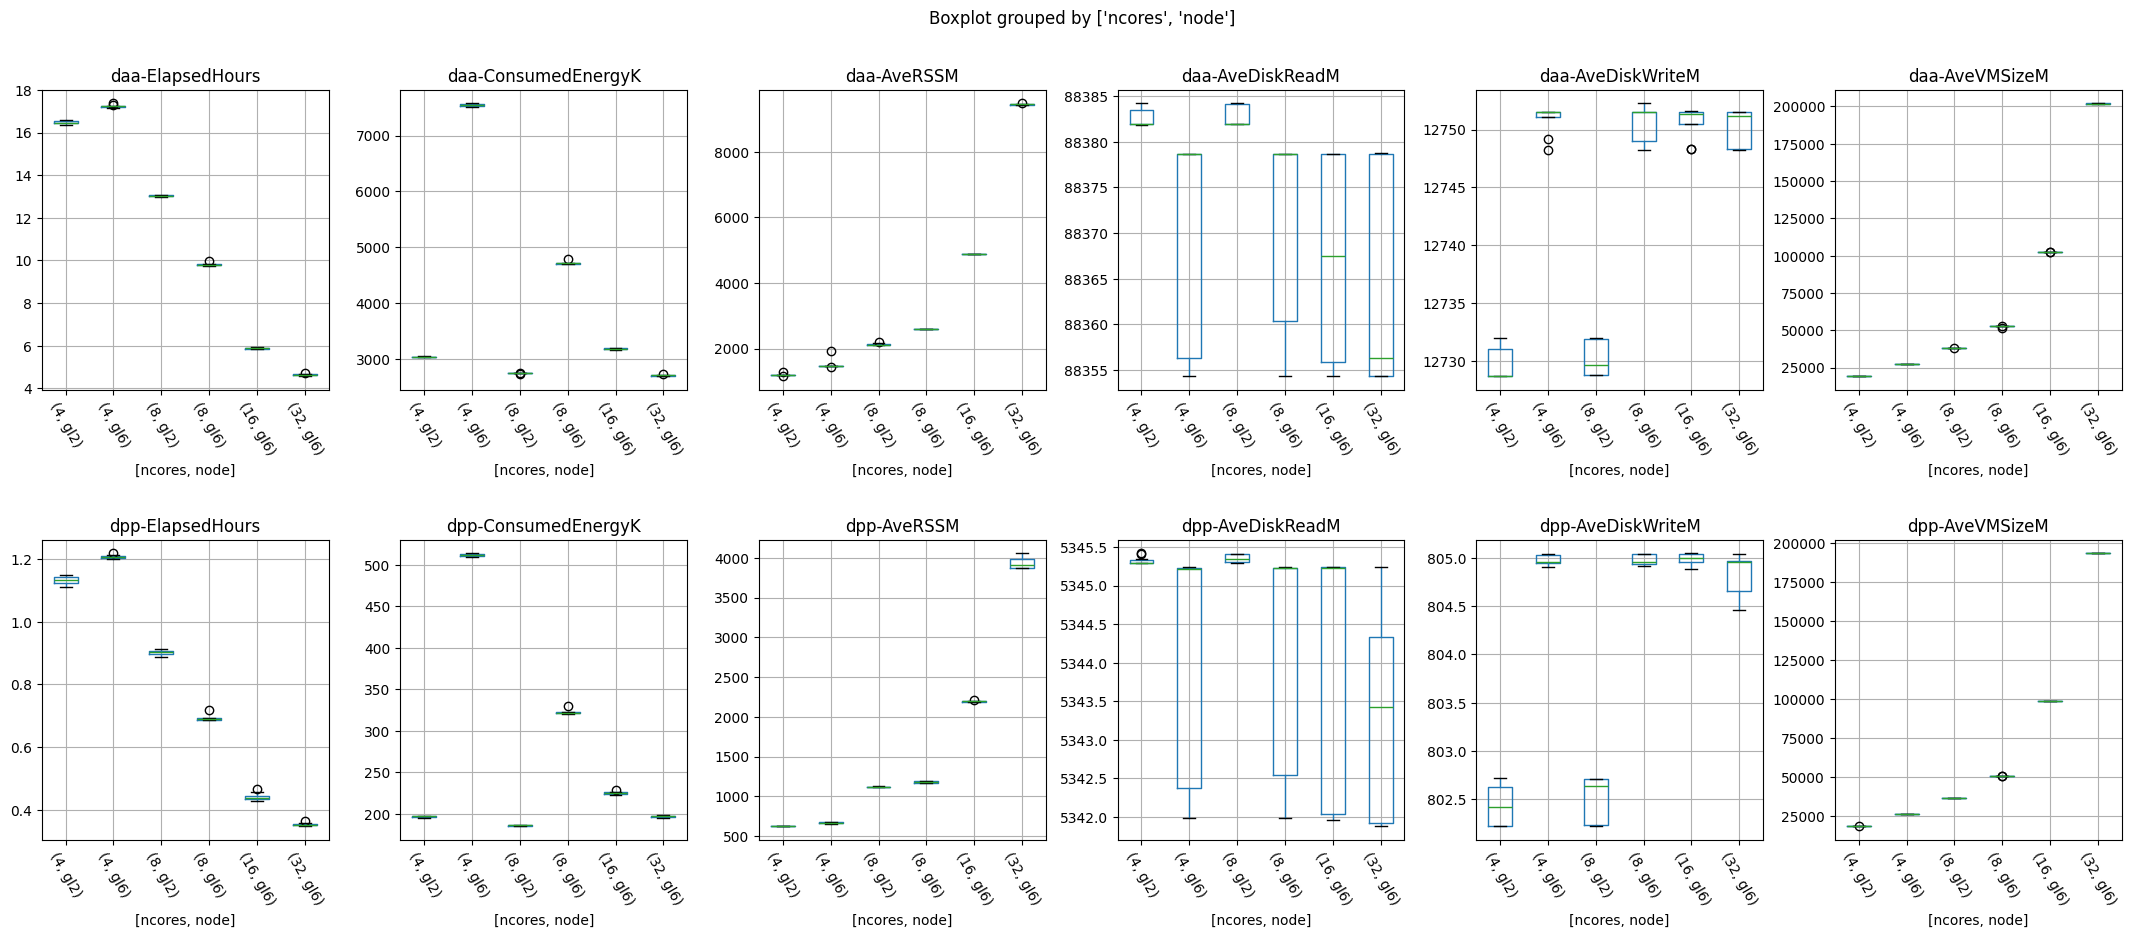

In [233]:
# draw two plots based on workflow containing multiple boxplots with data_for_analysis distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(26, 10))
for j, workflow in enumerate(data_for_analysis.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
        data_for_analysis[data_for_analysis.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'],
                                                                          ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        ax[j, i].set_xticklabels(ax[j, i].get_xticklabels(), rotation=-60)
        # next to every boxplot box show data_for_analysis distribution

fig.subplots_adjust(hspace=0.5, wspace=0.25)

fig.savefig('boxplot-overview-by-workflows.png')

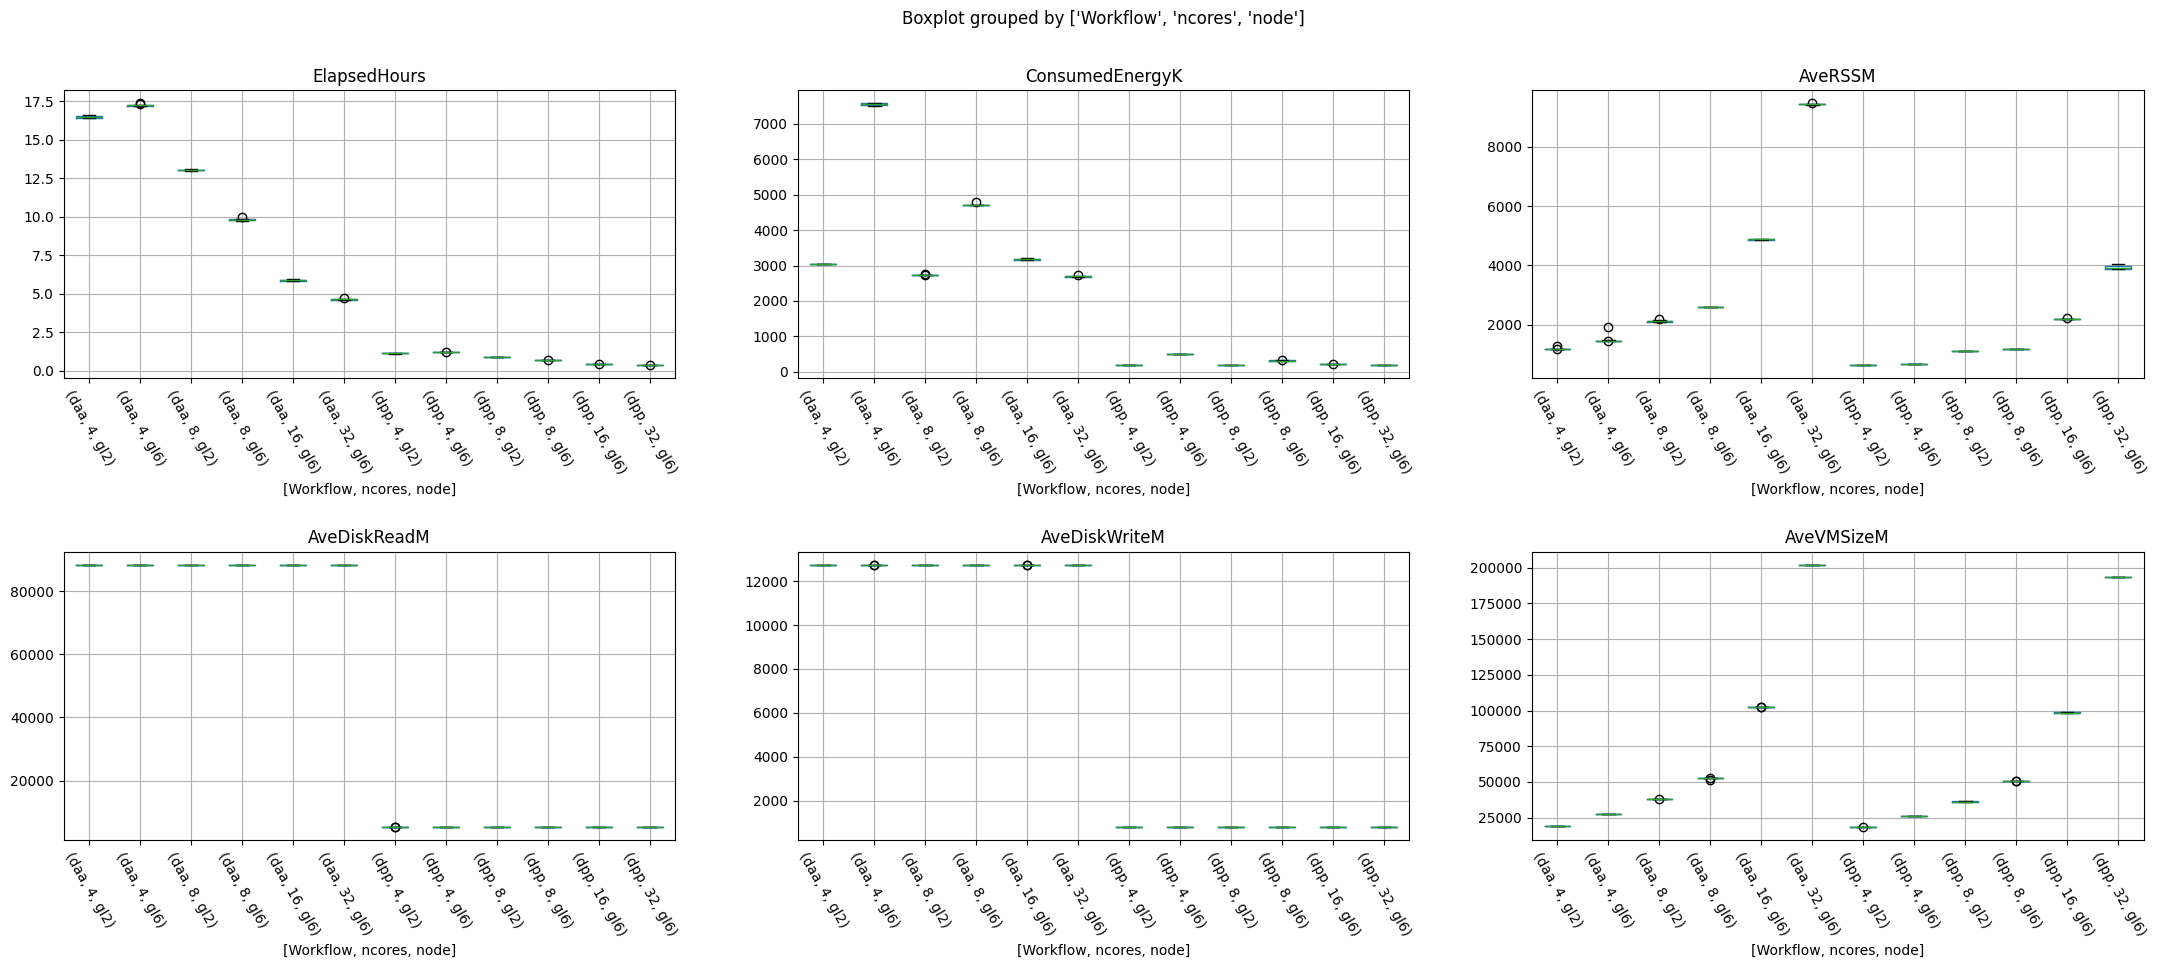

In [234]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))
for i, column in enumerate(
        ['ElapsedHours', 'ConsumedEnergyK', 'AveRSSM', 'AveDiskReadM', 'AveDiskWriteM', 'AveVMSizeM']):
    data_for_analysis.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)
    ax[i // 3, i % 3].set_xticklabels(ax[i // 3, i % 3].get_xticklabels(), rotation=-60)

fig.subplots_adjust(hspace=0.6)

fig.savefig('boxplot-overview.png')